<a href="https://colab.research.google.com/github/chillinandbilllin/BERT/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
pip install transformers==4.37.2


In [3]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

from transformers import TFBertModel, BertConfig, BertTokenizerFast

In [4]:
from google.colab import files

files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aviralsriv","key":"a187e1e971c470897ecd2dc1091b89c3"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle competitions download -c commonlitreadabilityprize


commonlitreadabilityprize.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip \*.zip


Archive:  commonlitreadabilityprize.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
train_path = 'train.csv'
test_path = 'test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [9]:
ex_len = []
for i in train_df['excerpt']:
  ex_len.append(len(i.split()))
print('max length of text: ', max(ex_len), 'words')

max length of text:  205 words


In [10]:
train_df['excerpt'][0]

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

In [11]:
bert_model = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(bert_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
def encoder(df, tokenizer, label = 'excerpt', maxLen = 210):
    input_id = []
    token_type = []
    attention_mask = []
    for i in df[label].values:
        token = tokenizer(i, max_length = maxLen, truncation = True, padding = 'max_length', add_special_tokens = True)
        input_id.append(token['input_ids'])
        token_type.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    return np.array(input_id), np.array(token_type), np.array(attention_mask)

In [13]:
train_d = encoder(train_df, tokenizer)
test_d = encoder(test_df, tokenizer)

In [14]:
train_d

(array([[  101,  2043,  1996, ...,  1010,  2021,   102],
        [  101,  2035,  2083, ...,  1010,  2017,   102],
        [  101,  2004,  5074, ...,  1010,  2205,   102],
        ...,
        [  101,  1996,  2117, ...,  4338,  2180,   102],
        [  101, 26778,  2024, ...,     0,     0,     0],
        [  101,  4176,  2024, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

In [15]:
tok = train_d[0].flatten()[30:50]

print(train_d[0].shape, '\n')
print('original sequence:')
print(train_df['excerpt'][0].split()[30:50], '\n')
print('tokenised sequence:')
print(tokenizer.convert_ids_to_tokens(tok), '\n')
print(tokenizer.convert_ids_to_tokens(train_d[0].flatten()[0:10]))

(2834, 210) 

original sequence:
['canvas,', 'not', 'laid', 'on', 'smoothly,', 'but', 'rumpled', 'over', 'bumps', 'and', 'hillocks,', 'like', 'a', 'real', 'snow', 'field.', 'The', 'numerous', 'palms', 'and'] 

tokenised sequence:
['floor', 'was', 'covered', 'with', 'snow', '-', 'white', 'canvas', ',', 'not', 'laid', 'on', 'smoothly', ',', 'but', 'rum', '##pled', 'over', 'bumps', 'and'] 

['[CLS]', 'when', 'the', 'young', 'people', 'returned', 'to', 'the', 'ballroom', ',']


In [16]:
model_config = BertConfig.from_pretrained(bert_model)

In [17]:
model_config.output_hidden_states = True

In [18]:
model_config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [19]:
bert = TFBertModel.from_pretrained(bert_model, config = model_config)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [20]:
max_len = 210
learning_rate = 1e-4
epochs = 3
optimizer = Adam(learning_rate = learning_rate)
loss = 'mse'
metrics = [RootMeanSquaredError()]


In [21]:
input_ids_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
token_type_ids_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'token_type_ids')
attention_mask_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')
inputs = [input_ids_i, token_type_ids_i, attention_mask_i]

bert_output = bert(input_ids_i, token_type_ids = token_type_ids_i, attention_mask = attention_mask_i)[0]
output = bert_output[:, 0, :]

output = Dropout(0.1)(output)

output = Dense(10, activation = 'linear')(output)
output = Dense(1, activation = 'linear')(output)

model = Model(inputs = inputs, outputs = output)

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 210)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 210)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 210)]                0         []                            
 )                                                                                                
                                                                                              

In [22]:
print(bert_output.shape)

(None, 210, 768)


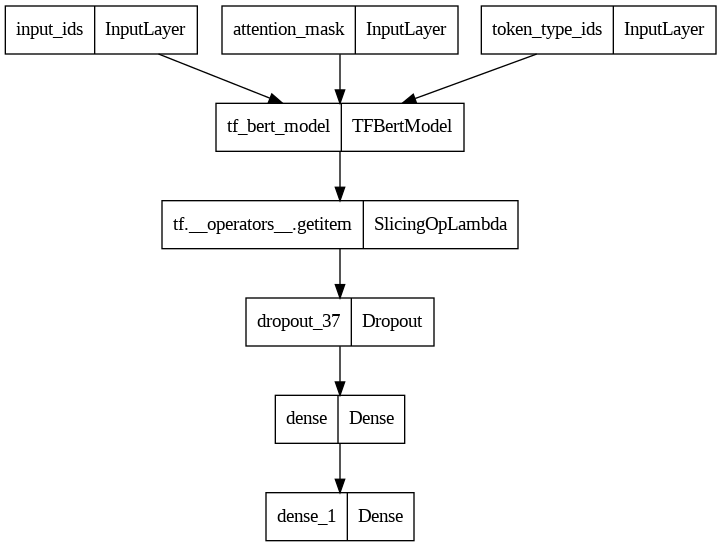

In [23]:
plot_model(model)

In [24]:
train_l = train_df['target'].values

val_prob = 0.1
split = int(len(train_l)*(1 - val_prob))
print(split)
print(2834 - split)
train_x = tuple(np.array(train_d)[:, :split, :])
train_y = train_l[:split]

val_x = tuple(np.array(train_d)[:, split:, :])
val_y = np.array(train_l[split:])
print(val_x[0].shape)
val_y.shape

2550
284
(284, 210)


(284,)

In [27]:
history=model.fit(train_x, train_y, validation_data = (val_x, val_y), epochs = 3)


Epoch 1/3
80/80 [==============================] - 120s 2s/step - loss: 0.1812 - root_mean_squared_error: 0.4256 - val_loss: 0.4510 - val_root_mean_squared_error: 0.6715
Epoch 2/3
80/80 [==============================] - 119s 1s/step - loss: 0.1189 - root_mean_squared_error: 0.3448 - val_loss: 0.3682 - val_root_mean_squared_error: 0.6068
Epoch 3/3
80/80 [==============================] - 119s 1s/step - loss: 0.0716 - root_mean_squared_error: 0.2676 - val_loss: 0.3818 - val_root_mean_squared_error: 0.6179


In [28]:
from matplotlib import pyplot as plt


<Figure size 800x500 with 0 Axes>

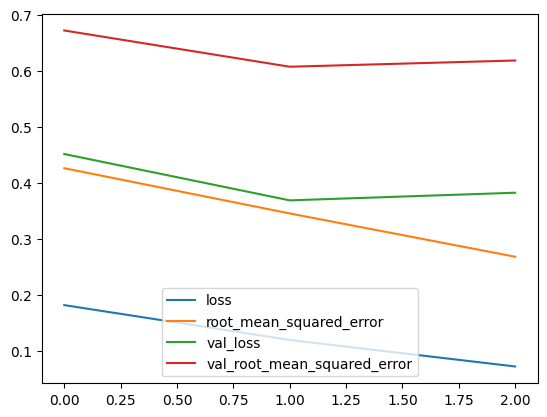

In [29]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [30]:
model.predict(test_d)

1/1 [==============================] - 0s 198ms/step


array([[-0.41893274],
       [-0.00419166],
       [-0.36397868],
       [-2.0788016 ],
       [-1.7488098 ],
       [-0.9671903 ],
       [ 0.5450838 ]], dtype=float32)